In [1]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import networkx as nx
import torch
from matplotlib import pyplot as plt
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import f1_score

import generators as gen
import optimize as opt
import helpers as hlp
from NNet import NNet

from mpl_toolkits.basemap import Basemap

%load_ext autoreload
%autoreload 2

from impyute.imputation.cs import mice

In [ ]:
def plot_results(imp, h):
    plt.figure(figsize=(12,4))
    
    plt.subplot(131)
    plt.imshow(imp>.5)
    plt.title('Rounded Imputed Values')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(imp)
    plt.title('Imputed Values')
    plt.axis('off')

    L = hlp.A_to_L(imp>.5)
    plt.subplot(133)
    evals, _ = np.linalg.eig(L)
    x = torch.Tensor(np.linspace(0.01,evals.max()+1, num=100)).unsqueeze_(-1)
    plt.plot(x.numpy(), h(x).detach().numpy())
    plt.legend(['Fitted', 'True'])
    plt.xlabel('Eigenvalue')
    plt.ylabel('Kernel');

In [ ]:
fn = 'data/Complete_TAVG_EqualArea.nc'
ds = nc.Dataset(fn)

In [4]:
temp = np.array(ds['temperature'])
time = np.array(ds['time'])
long = np.array(ds['longitude'])
lati = np.array(ds['latitude'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [5]:
touse_xy = (lati>=36) & (lati <65) & (long>-11) & (long < 30)
touse_t = ~np.isnan(temp[:,touse_xy].sum(axis=1))

In [7]:
np.random.seed(42)
use_for_test = np.random.uniform(size=len(touse_t)) > .95
train_ix = touse_t & ~use_for_test
test_ix = touse_t & use_for_test

In [8]:
temp_train = temp[train_ix][:, touse_xy]
temp_test = temp[test_ix][:, touse_xy]
#time_use = time[touse_t]
long_use = long[touse_xy]
lati_use = lati[touse_xy]

In [9]:
imp, hist, h = opt.impute_graph(temp_train, lr=.01, nit_nnet=3, lr_nnet=1e-5,
                               n_epochs=3000)

[Epoch 3000/3000] loss: 50.3495032

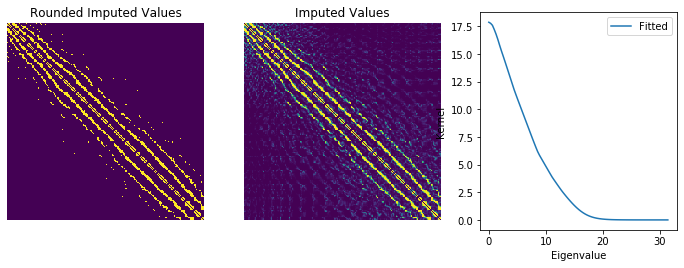

In [10]:
plot_results(imp, h)

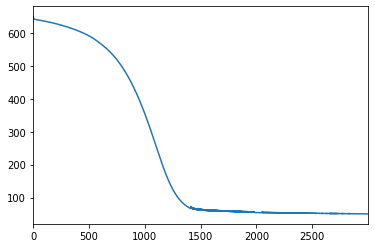

In [11]:
hist.Loss.plot();

# Interpolate Missing Values

In [12]:
def plot_graph(adj, color, cmapname='coolwarm', vmin=None, vmax=None):
    fig = plt.figure(figsize=(8, 8))
    m = Basemap(projection='lcc', resolution=None,
                width=4E6, height=4E6, 
                lat_0=lati_use.mean(), lon_0=long_use.mean(),)
    m.etopo(scale=0.5, alpha=0.5)

    pos_dict = {i: m(lo, la) for i, (lo, la) in enumerate(zip(long_use, lati_use))}
    nx.draw(nx.from_numpy_array(adj), pos=pos_dict, 
            cmap=plt.get_cmap(cmapname), node_color=color,
            vmin=vmin, vmax=vmax)


In [13]:
def find_missing(adj, h, signal, mask=None, lr=1e-2, n_iters=1000, 
                 seed=42, verbose=None):
    if mask is None:
        mask = ~np.isnan(signal)
        
    target = torch.Tensor(signal[mask])
    tot_nodes = mask.sum()
    
    L = hlp.A_to_L(adj)
    h_of_L = gen.filter_matrix(L, h)
    
    torch.manual_seed(seed)
    np.random.seed(seed)
     
    #generating = torch.Tensor(np.zeros(shape=signal.shape))
    generating = torch.Tensor(np.random.normal(size=signal.shape))
    generating.requires_grad = True
    optimizer = torch.optim.Adam([generating], lr=lr)
    
    for i in range(int(n_iters)):
        optimizer.zero_grad()
        filtered = generating @ h_of_L
        loss = ((filtered[mask] - target)**2).sum() / tot_nodes
        loss.backward()
        optimizer.step()
        
        if verbose and (i%verbose==0 or i==int(n_iters - 1)):
            print('\rIteration {}: Loss {}'.format(i+1, loss.item()), end='')
    
    out = gen.filter_signal(generating, L, h).detach().numpy()
    out[mask] = signal[mask]
    
    return generating, out
        


In [16]:
np.random.seed(3)
mask = np.random.uniform(size=temp_test.shape[1])>.9

In [56]:
interp = np.array([find_missing(imp, h, sign, mask, lr=1e-2, n_iters=2000, verbose=False)[1]
                   for sign in temp_test])

# Compare Interpolations

In [18]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from impyute.imputation.cs import em, fast_knn

In [19]:
mice_data = temp[:, touse_xy].copy().astype(np.float)
mice_data[np.outer(test_ix, ~mask)] = np.nan
mice_data = mice_data[touse_t]
em_interp = em(mice_data)
knn_interp = fast_knn(mice_data)
mice_interp = mice(mice_data)

KeyboardInterrupt: 

In [22]:
np.save('res/em_interp.npy', em_interp)
np.save('res/knn_interp.npy', knn_interp)
np.save('res/ours_interp.npy', interp)

In [75]:
def mse(interp, true, mask):
    return ((interp[:,~mask] - true[:,~mask])**2).sum(axis=1) / len(interp)
    #return ((interp[:,mask] - true[:,mask])**2).sum(axis=1) / len(interp)

In [76]:
mse_em = mse(em_interp[test_ix[touse_t]], temp_test, mask)
mse_knn = mse(knn_interp[test_ix[touse_t]], temp_test, mask)
mse_ours = mse(interp, temp_test, mask)

In [77]:
print(mse_em.mean(), mse_knn.mean(), mse_ours.mean())

6.531933717827127 3.416841113548773 0.3329246


In [78]:
print(mse_em.std(), mse_knn.std(), mse_ours.std())

3.57453873589178 3.4442510316183435 0.20578673


array([[-1.46067313,  3.78950947,  2.85368353, ...,  0.65847068,
        -1.79564895, -1.42332579],
       [-1.27971078,  0.33979744,  1.97164775, ..., -0.76209239,
         0.27639574,  0.17212359],
       [ 1.58418074, -2.36567535, -0.01158789, ..., -1.38687157,
        -1.13796754, -0.67705157],
       ...,
       [-1.43905964, -1.1418624 ,  3.96480262, ..., -0.01384942,
        -0.78071645, -0.42645798],
       [ 1.20001665,  0.51889452,  0.54924303, ...,  3.27296682,
        -2.36468101,  1.05869372],
       [-0.65364226,  0.67352007, -1.23739514, ..., -0.3681046 ,
         2.02203279, -0.70106404]])

# Plot Result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


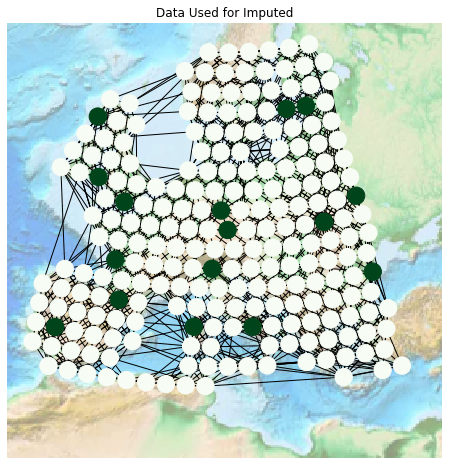

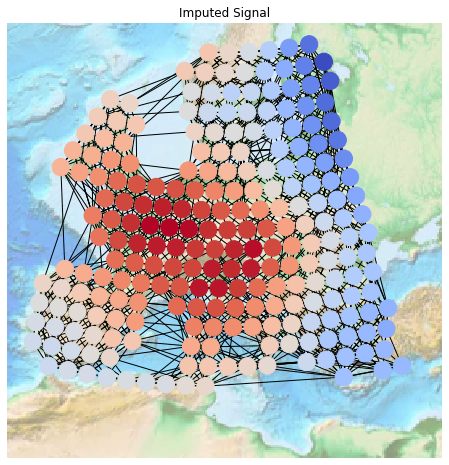

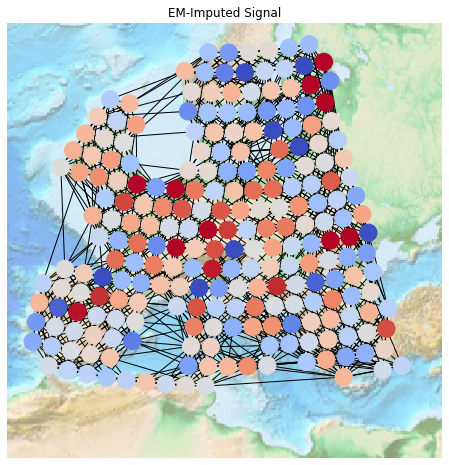

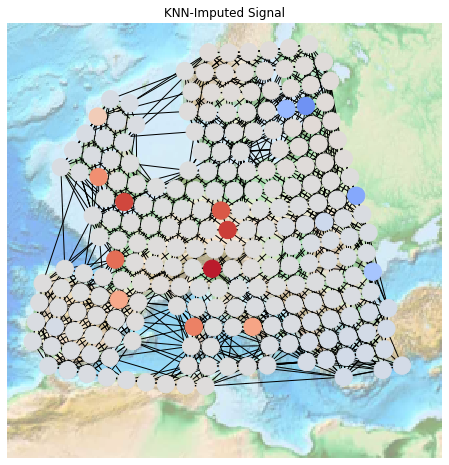

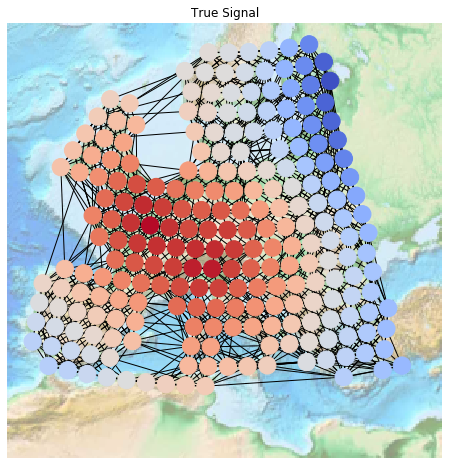

In [74]:
ix = 3

vmin = min(interp[ix].min(), temp_test[ix].min())
vmax = max(interp[ix].max(), temp_test[ix].max())

plot_graph(imp > .5, mask, 'Greens')
plt.title('Data Used for Imputed')
plt.savefig('res/interp_mask.png')
plot_graph(imp > .5, interp[ix], vmin=vmin, vmax=vmax)
plt.title('Imputed Signal')
plt.savefig('res/interp_pred.png')
plot_graph(imp > .5, em_interp[test_ix[touse_t]][ix], vmin=vmin, vmax=vmax)
plt.title('EM-Imputed Signal')
plt.savefig('res/interp_em.png')
plot_graph(imp > .5, knn_interp[test_ix[touse_t]][ix], vmin=vmin, vmax=vmax)
plt.title('KNN-Imputed Signal')
plt.savefig('res/interp_knn.png')
plot_graph(imp > .5, temp_test[ix], vmin=vmin, vmax=vmax)
plt.title('True Signal')
plt.savefig('res/interp_true.png')

